In [1]:
import math, copy
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon

In [2]:
# Helper functions
EPS = 1e-9
def perp_bisector_line(s, t):
    sx, sy = s; tx, ty = t
    a = tx - sx; b = ty - sy
    c = (sx*sx + sy*sy - tx*tx - ty*ty)/2.0
    return a,b,c

def inside_halfplane(pt, a,b,c):
    return (a*pt[0] + b*pt[1] + c) <= EPS

def line_intersection(p1, p2, a,b,c):
    x1,y1 = p1; x2,y2 = p2
    v1 = a*x1 + b*y1 + c; v2 = a*x2 + b*y2 + c
    if abs(v1 - v2) < EPS:
        return ((x1+x2)/2.0, (y1+y2)/2.0)
    t = v1 / (v1 - v2)
    return (x1 + (x2-x1)*t, y1 + (y2-y1)*t)

def clip_polygon_with_halfplane(polygon, a,b,c):
    if not polygon: return []
    out = []
    n = len(polygon)
    for i in range(n):
        cur = polygon[i]; prev = polygon[i-1]
        inside_cur = inside_halfplane(cur,a,b,c); inside_prev = inside_halfplane(prev,a,b,c)
        if inside_prev and inside_cur:
            out.append(cur)
        elif inside_prev and not inside_cur:
            ip = line_intersection(prev, cur, a,b,c); out.append(ip)
        elif not inside_prev and inside_cur:
            ip = line_intersection(prev, cur, a,b,c); out.append(ip); out.append(cur)
    # remove near-duplicates
    clean = []
    for p in out:
        if not clean or (abs(clean[-1][0]-p[0])>1e-8 or abs(clean[-1][1]-p[1])>1e-8):
            clean.append(p)
    return clean if len(clean) >= 3 else []

In [3]:
# Define the cell class
class Cell:
    def __init__(self, site, polygon):
        self.site = tuple(site); self.polygon = polygon


In [4]:
# Visualization functions
def make_bbox(minx, miny, maxx, maxy):
    return [(minx,miny),(maxx,miny),(maxx,maxy),(minx,maxy)]

def plot_polygon(ax, poly, **kwargs):
    if not poly: return
    patch = MplPolygon(poly, closed=True, **kwargs)
    ax.add_patch(patch)

def line_segment_for_plot(a,b,c,bbox):
    minx = min(p[0] for p in bbox); maxx = max(p[0] for p in bbox)
    miny = min(p[1] for p in bbox); maxy = max(p[1] for p in bbox)
    pts = []
    if abs(b) > 1e-12:
        pts.append((minx, (-c - a*minx)/b)); pts.append((maxx, (-c - a*maxx)/b))
    if abs(a) > 1e-12:
        pts.append(((-c - b*miny)/a, miny)); pts.append(((-c - b*maxy)/a, maxy))
    filtered = [p for p in pts if (minx-1 <= p[0] <= maxx+1) and (miny-1 <= p[1] <= maxy+1)]
    unique = []
    for p in filtered:
        if p not in unique: unique.append(p)
    if len(unique) < 2: return None
    best, bestd = None, -1
    for i in range(len(unique)):
        for j in range(i+1, len(unique)):
            d = math.hypot(unique[i][0]-unique[j][0], unique[i][1]-unique[j][1])
            if d > bestd: bestd = d; best=(unique[i], unique[j])
    return best

In [5]:
# Example entries
sites = [(2.0, 2.0), (7.0, 2.5), (4.5, 6.0), (8.5, 7.0)]
bbox = make_bbox(0, 0, 10, 10)


=== Insert site 1: (2.0, 2.0) ===
 - first site: cell is the whole bounding box


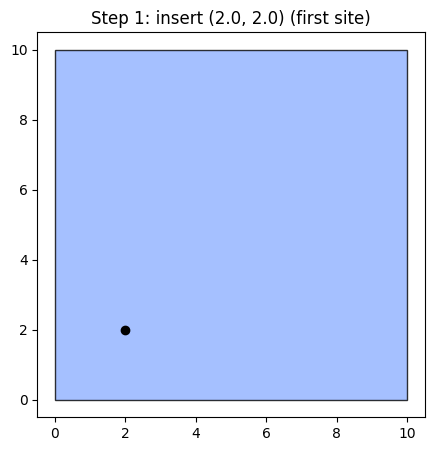


=== Insert site 2: (7.0, 2.5) ===
 - polygons before clipping:
    cell 1 site=(2.0, 2.0) vertices=4
 - after clipping:
    cell 1 site=(2.0, 2.0) vertices=4
    cell 2 site=(7.0, 2.5) vertices=4


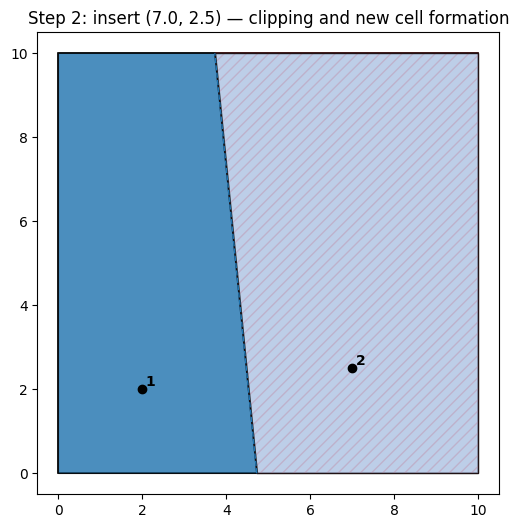


=== Insert site 3: (4.5, 6.0) ===
 - polygons before clipping:
    cell 1 site=(2.0, 2.0) vertices=4
    cell 2 site=(7.0, 2.5) vertices=4
 - after clipping:
    cell 1 site=(2.0, 2.0) vertices=4
    cell 2 site=(7.0, 2.5) vertices=4
    cell 3 site=(4.5, 6.0) vertices=5


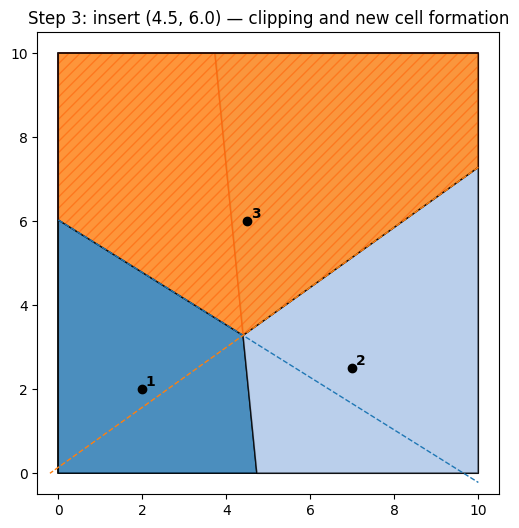


=== Insert site 4: (8.5, 7.0) ===
 - polygons before clipping:
    cell 1 site=(2.0, 2.0) vertices=4
    cell 2 site=(7.0, 2.5) vertices=4
    cell 3 site=(4.5, 6.0) vertices=5
 - after clipping:
    cell 1 site=(2.0, 2.0) vertices=4
    cell 2 site=(7.0, 2.5) vertices=5
    cell 3 site=(4.5, 6.0) vertices=5
    cell 4 site=(8.5, 7.0) vertices=4


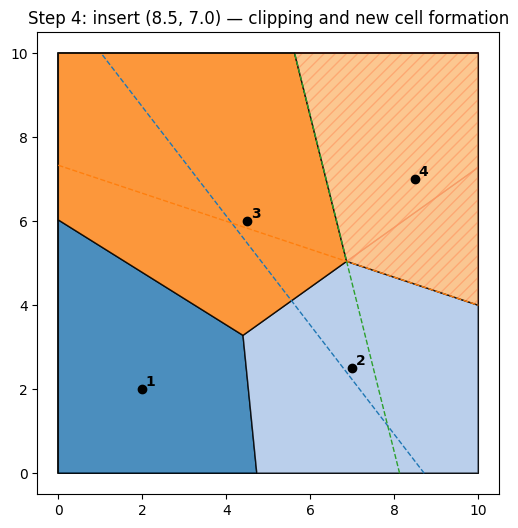

In [ ]:
cells = []
step_figs = []

for i, s in enumerate(sites):
    print(f"\n=== Insert site {i+1}: {s} ===")
    if not cells:
        cells.append(Cell(s, bbox.copy()))
        print(" - first site: cell is the whole bounding box")
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_title(f"Step {i+1}: insert {s} (first site)")
        plot_polygon(ax, bbox, facecolor='#8fb1ff', edgecolor='k', alpha=0.8)
        ax.scatter([s[0]],[s[1]], color='k', zorder=5)
        ax.set_xlim(-0.5,10.5); ax.set_ylim(-0.5,10.5)
        plt.show()
        step_figs.append(fig)
        continue

    print(" - polygons before clipping:")
    for j,cell in enumerate(cells):
        print(f"    cell {j+1} site={cell.site} vertices={len(cell.polygon)}")

    prev_polys = [copy.deepcopy(c.polygon) for c in cells]
    removed_pieces = []

    # clip existing cells against half-plane "closer to old site than to new site"
    for j, cell in enumerate(cells):
        a,b,c = perp_bisector_line(cell.site, s) 
        new_poly = clip_polygon_with_halfplane(cell.polygon, a,b,c)
        removed = None
        if cell.polygon and new_poly:
            removed_pts = [p for p in cell.polygon if p not in new_poly]
            for k in range(len(cell.polygon)):
                p1 = cell.polygon[k-1]; p2 = cell.polygon[k]
                if inside_halfplane(p1,a,b,c) != inside_halfplane(p2,a,b,c):
                    ip = line_intersection(p1,p2,a,b,c); removed_pts.append(ip)
            if len(removed_pts) >= 3:
                pts = sorted(set(removed_pts))
                def cross(o,a,b): return (a[0]-o[0])*(b[1]-o[1]) - (a[1]-o[1])*(b[0]-o[0])
                lower=[]
                for p in pts:
                    while len(lower)>=2 and cross(lower[-2], lower[-1], p) <= 0: lower.pop()
                    lower.append(p)
                upper=[]
                for p in reversed(pts):
                    while len(upper)>=2 and cross(upper[-2], upper[-1], p) <= 0: upper.pop()
                    upper.append(p)
                hull = lower[:-1] + upper[:-1]
                removed = hull
        else:
            if cell.polygon and not new_poly:
                removed = cell.polygon.copy()
        cell.polygon = new_poly
        if removed: removed_pieces.append((j, removed))

    # build new cell by clipping bbox against all existing sites (keep points closer to new site)
    new_poly = bbox.copy()
    for cell in cells:
        a,b,c = perp_bisector_line(s, cell.site)
        new_poly = clip_polygon_with_halfplane(new_poly, a,b,c)
        if not new_poly: break
    cells.append(Cell(s, new_poly))

    print(" - after clipping:")
    for j,cell in enumerate(cells):
        print(f"    cell {j+1} site={cell.site} vertices={len(cell.polygon)}")

    # plot annotated step
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(f"Step {i+1}: insert {s} — clipping and new cell formation")
    plot_polygon(ax, bbox, facecolor='none', edgecolor='k', linewidth=1.2)
    cmap = plt.get_cmap("Pastel1")
    for idx, prev_poly in enumerate(prev_polys):
        if prev_poly: plot_polygon(ax, prev_poly, facecolor=cmap(idx%8), edgecolor='k', alpha=0.25)
    for (idx, removed) in removed_pieces:
        plot_polygon(ax, removed, facecolor='none', edgecolor='r', hatch='///', linewidth=0.8, alpha=0.6)
    for idx, cell in enumerate(cells[:-1]):
        a,b,c = perp_bisector_line(cell.site, s)
        seg = line_segment_for_plot(a,b,c,bbox)
        if seg:
            (x1,y1),(x2,y2) = seg
            ax.plot([x1,x2],[y1,y2], linestyle='--', linewidth=1.0)
    cmap2 = plt.get_cmap("tab20")
    for idx, cell in enumerate(cells):
        if cell.polygon: plot_polygon(ax, cell.polygon, facecolor=cmap2(idx%20), edgecolor='k', alpha=0.8)
        ax.scatter([cell.site[0]],[cell.site[1]], color='k', zorder=5)
        ax.text(cell.site[0]+0.08, cell.site[1]+0.08, f"{idx+1}", fontsize=10, weight='bold')
    ax.set_xlim(-0.5,10.5); ax.set_ylim(-0.5,10.5); ax.set_aspect('equal','box')
    plt.show()
    step_figs.append(fig)

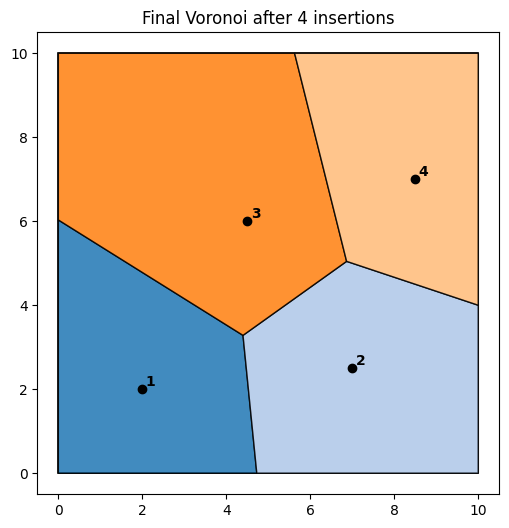

In [7]:
# final diagram
figf, axf = plt.subplots(figsize=(6,6))
axf.set_title("Final Voronoi after 4 insertions")
plot_polygon(axf, bbox, facecolor='none', edgecolor='k', linewidth=1.2)
cmap2 = plt.get_cmap("tab20")
for idx, cell in enumerate(cells):
    if cell.polygon: plot_polygon(axf, cell.polygon, facecolor=cmap2(idx%20), edgecolor='k', alpha=0.85)
    axf.scatter([cell.site[0]],[cell.site[1]], color='k', zorder=5)
    axf.text(cell.site[0]+0.08, cell.site[1]+0.08, f"{idx+1}", fontsize=10, weight='bold')
axf.set_xlim(-0.5,10.5); axf.set_ylim(-0.5,10.5); axf.set_aspect('equal','box')
plt.show()